# Chapter 11 : Implementing a Multilayer Artificial Neural Network from Scratch

## Modeling complex functions with artificial neural networks

Note that a *neural network* originates in the 1940s with models such as ADALINE and the perceptron, already covered in this book.  Neural networks have become more populated after the ability to create *deep neural networks* which have multiple layers of neurons.

### Single layer neural network recap

For example, consider ADALINE.  Recall that in every epoch, the weight vector, $w$, and bias unit, $b$, are updated. Where
$$
    w := w + \Delta w \text{ and } b := b + \Delta b
$$
and
$$
    \Delta w_j = -\eta \frac{\partial L}{\partial w_j}
$$
and
$$
    \Delta b = -\eta\frac{\partial L}{\partial b}
$$

This is done through multiple passes over the training set where an activiation function (in ADALINE, the identity function) output is compared with the actual value.  Recall that this takes the opposite direction of the loss gradient ($\nabla L(w)$) to find optimal weights of the model.  Generally $L$ is defined as the mean of square errors.  The model learning phase is accelerated by stochastic gradient descent.

This will be used to implement and train a *multilayer perceptron* (MLP) model.

### Introducing the multilayer neural network architecture

A MLP model consists in an input layer, one or more hidden layers, and an output payer. If a network has more than one hidden layer, then it is said to be a *deep NN*. 

The $i$th activation unit in the $l$th later is denoted $a_i^{(l)}$.  Numerical units are usally not used for the layers; therfore, $x_i^{(in)}$ refers to the $i$th input feature value, $a_i^{(h)}$ refers to the $i$th unit in the hidden layer, and $a_i^{(out)}$ refers to the $i$th unit in the output layer. $b^{(h)}$, $b^{(out)}$ denote bias unit vectors storing $d$, the number of nodes, bias units for the hidden and output layers.

### Activating a neural network via forward propagation

The MLP procedure is summarized in three steps:
1. Starting at $x_i^{(in)}$, patterns are forward propagated through the network
2. Based on network output, calculate the loss we want to minimize using a loss function
3. Back propogate the loss, finding the derivative of each weight and bias unity, updating the model
These steps are repeated for each epoch. 

Moving step by step as follows.  First, calcualte the activation unit for the hidden layer as follows:
$$
    z_1^{(h)} = x_1^{(in)}w_{1,1}^{(h)} + \dots + x_m^{(in)}w_{1,m}^{(h)}
$$
thus,
$$
    a_1^{(h)} = \sigma(z_1^{(h)})
$$
Note that complex problems need a nonlinear activation function.  For example, the logistic regression's sigmoid activation function.

The calculation can be generalized to $n$ examples as follows:
$$
    Z^{(h)}= X^{(in)}W^{{h)T} + b^{(h)}
$$
Thus:
$$
    A^{(h)} = \sigma(Z^{(h)})
$$
And finally:
$$
    A^{(out)} = \sigma(Z^{(out)})
$$

## Classifying handwritten digits

Before implementing a multilayer perceptron, prepare the handwritten digits data set.

Get data set from sci-kit learn.print(X.shape)

In [1]:
from sklearn.datasets import fetch_openml 
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [2]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize the pixels. Recall that gradient-based optimization is better using normalized data. 

In [3]:
X = ((X / 255.) - .5) * 2

Split the data.

In [4]:
from sklearn.model_selection import train_test_split 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

### Implementing a multilayer perceptron

This will implement a MLP with a single hidden layer.

Write helper functions to calculate sigmoid function and to encode labels.

In [5]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

Make the NeuralNetMLP class.

Notes:
1. `__init__` : This instantiates the weights for both the output and hidden layers
2. `.forward` : Uses training examples to make a prediction. `a_h` contains the activation values of the hidden layer, and `a_out` contains the class membership probabilities
3. `.backward`  : Updates the weight and bias parameters of the network.  This is called the *backpropagation* algorithm.  This is done by calculating the loss gradient, and returning the updated bias and weights for the hidden layer and the membership probabilities.

In [9]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden,
                 num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        # hidden
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
    
    def forward(self, x): 
        # Hidden layer
        # input dim: [n_hidden, n_features]
        # dot [n_features, n_examples] .T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h 
        a_h = sigmoid(z_h)
        # Output layer
        # input dim: [n_classes, n_hidden]
        # dot [n_hidden, n_examples] .T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out 
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        #########################
        ### Output layer weights
        #########################
        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0] 
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) 
        # sigmoid derivative # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        # gradient for output weights
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        # input dim: [n_classes, n_examples]
        # dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out) 
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet
        #    * dHiddenNet/dWeight
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) 
        # sigmoid derivative
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T,
                        d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

Initialize a new model:

In [10]:
model = NeuralNetMLP(num_features=28*28,
    num_hidden=50,
    num_classes=10)

### Coding the Neural Network training loop

Define a helper function to generate mini matches of the data set:

In [14]:
import numpy as np
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size] 
        yield X[batch_idx], y[batch_idx]
        
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(
    targets, num_labels=num_labels
    )
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

Get the minibatches.

In [16]:
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Now predict on the model using `.forward`.  This returns the hidden and output layer activations.  From this, the accuracy can be calculated.

In [17]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [19]:
def compute_mse_and_acc(nnet, X, y, num_labels=10,
    minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(
        targets, num_labels=num_labels
        )
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [20]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


Now develope a `train` function which will handle the layers.  It will
- iterate over multiple epochs
- uses mini-batches to iterate over the training set
- use `.forward()` to obtain output
- use `.backward()` to compute gradient loss and update weights

In [24]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for e in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)
            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train_mini, a_h, a_out,
            y_train_mini) 
            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(
        model, X_train, y_train
        )
        valid_mse, valid_acc = compute_mse_and_acc(
        model, X_valid, y_valid
        )
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
        f'| Train MSE: {train_mse:.2f} '
        f'| Train Acc: {train_acc:.2f}% '
        f'| Valid Acc: {valid_acc:.2f}%')
    return epoch_loss, epoch_train_acc, epoch_valid_acc

Now call the `train` function over 50 epochs.

In [25]:
np.random.seed(123) # for the training set shuffling 
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.03 | Train Acc: 85.39% | Valid Acc: 84.96%
Epoch: 002/050 | Train MSE: 0.02 | Train Acc: 87.91% | Valid Acc: 87.58%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 89.20% | Valid Acc: 89.06%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 90.17% | Valid Acc: 89.94%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.78% | Valid Acc: 90.52%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 91.10% | Valid Acc: 90.92%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.48% | Valid Acc: 91.04%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 91.75% | Valid Acc: 91.44%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 92.12% | Valid Acc: 91.78%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.10%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.28%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.68% | Valid Acc: 92.34%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.81% | Valid Acc: 92.58%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.97

By prinitng the output, it is possible to see the changes in train and valid accuracies. 

Note that deep NN are computationally expensive relative to other forms of machine learning. Therefore, using the information that is prited out, it is possible to stop and try different hyperparameters. 

### Evaluating the neural network performance

Consider MSE over epochs. Consider:
- significant improvement in MSE metric over the first ten epochs
- improvement change decreases in the later epochs
- but the slop at epochs 40-50 indicate that more epochs would lead to improvement in the MSE metric, if the computational resources justified it (especially because the model is not overfitting to train data)

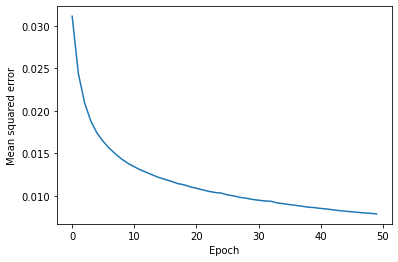

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(len(epoch_loss)), epoch_loss) 
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

However, plotting the train and validate accuracy shows that eventually there are minimal gains in validation accuracy at higher number of epochs.

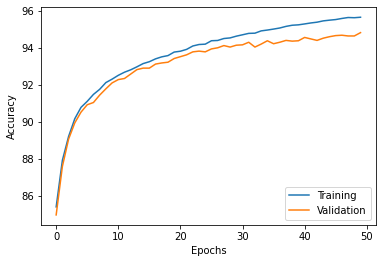

In [28]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right') 
plt.show()

Note that test accuracy is high.

In [29]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test) 
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.61%


To further improve the model, the following can be tuned:
- $\eta$, the learning rate
- number of hidden layers
Other advanced techniques are:
- change $\eta$ during training via learning rate schedulers
- attaching loss functions to earlier layers

## Training an artificial neural network

### Computing the loss function

